# 1. Libraries

In [2]:
%load_ext autoreload
%autoreload 2
import discrimination
import pandas as pd
import pickle
import os
import numpy as np
import random
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Dense, Activation, Flatten, Dropout
from keras.models import Sequential
from keras import regularizers
import matplotlib.pyplot as plt
import itertools
import tqdm
import seaborn

INFO: {'User-Agent': 'Mozilla/5.0 (Windows NT 5.2; RW; rv:7.0a1) Gecko/20091211 SeaMonkey/9.23a1pre'}
Using Theano backend.


# 2. Data Preperation

## Create lists containg all the *English* texts, clean them up, etc., and finally save them.

Download from Mongo all the texts collected (tables are named diary.com, my-diary.org and everydaysexism) and create lists with them, one for each table.

In [2]:
texts_diary=[]
texts_mydiary = []
texts_everydaysexism = []

table = discrimination.mongo.collection(collection= "diary.com")
for x in table.find():
    texts_diary.append(x['text'])

table = discrimination.mongo.collection(collection= "my-diary.org")
for x in table.find():
    texts_mydiary.append(x['text'])

table = discrimination.mongo.collection(collection= "everydaysexism")
for x in table.find():
    texts_everydaysexism.append(x['text'])

In [8]:
print(len(texts_diary), "texts collected from diary.com")
print(len(texts_mydiary), "texts collected from my-diary.org")
print(len(texts_everydaysexism), "texts collected from everydaysexism.com")

29696 texts collected from diary.com
40555 texts collected from my-diary.org
97385 texts collected from everydaysexism.com


From each list of texts, keep only the ones in English. This process takes a long time... a timer is printed every 10,000 texts (by default).

In [ ]:
texts_diary = discrimination.texts.keep_english(texts_diary)
texts_mydiary = discrimination.texts.keep_english(texts_mydiary)
texts_everydaysexism = discrimination.texts.keep_english(texts_everydaysexism)

Clean the texts from urls, html, hastags; then make them lowercase.

In [ ]:
texts_diary = discrimination.texts.clean(texts_diary)
texts_mydiary = discrimination.texts.clean(texts_mydiary)
texts_everydaysexism = discrimination.texts.clean(texts_everydaysexism)

texts_diary = discrimination.texts.lowercase(texts_diary)
texts_mydiary = discrimination.texts.lowercase(texts_mydiary)
texts_everydaysexism = discrimination.texts.lowercase(texts_everydaysexism)

Save the text-lists using Pickle to avoid redoing this.

In [11]:
# Save
# pickle.dump(texts_diary, open("pickles/texts_diary.p", "wb"))
# pickle.dump(texts_mydiary, open("pickles/texts_mydiary.p", "wb"))
# pickle.dump(texts_everydaysexism, open("pickles/texts_everydaysexism.p", "wb"))

# Load
texts_diary = pickle.load(open("pickles/texts_diary.p", "rb"))
texts_mydiary = pickle.load(open("pickles/texts_mydiary.p", "rb"))
texts_everydaysexism = pickle.load(open("pickles/texts_everydaysexism.p", "rb"))

In [12]:
print(len(texts_diary), "texts collected from diary.com after cleaning")
print(len(texts_mydiary), "texts collected from my-diary.org after cleaning")
print(len(texts_everydaysexism), "texts collected from everydaysexism.com after cleaning")

21056 texts collected from diary.com after cleaning
37058 texts collected from my-diary.org after cleaning
97044 texts collected from everydaysexism.com after cleaning


## Split my-diary.org texts in sentences

This step is done in order to split up the non-sexist texts from my-diary.org (since they are too long) in order to match the length of the sexist texts from everydaysexism. This greatly increases the number of texts obtained from my-diary.org (roughly by 10 times).

In [13]:
sentences_diary = discrimination.texts.sentences_split(texts_diary)
sentences_mydiary = discrimination.texts.sentences_split(texts_mydiary)
sentences_everydaysexism = discrimination.texts.sentences_split(texts_everydaysexism)

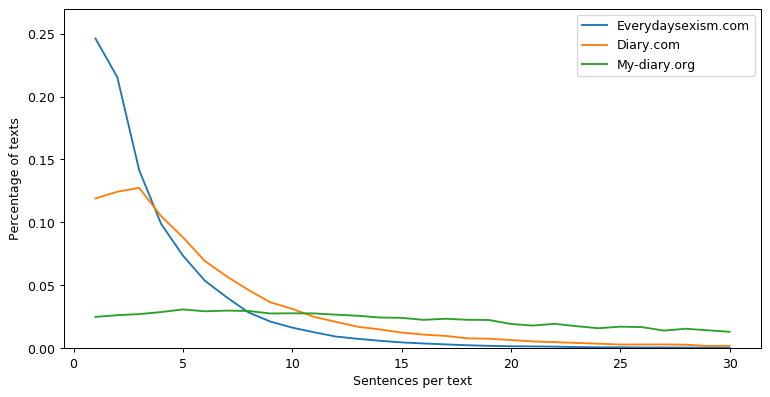

In [14]:
list_of_texts = [sentences_everydaysexism, sentences_diary, sentences_mydiary]
legend = ["Everydaysexism.com", "Diary.com", "My-diary.org"]
discrimination.texts.sentences_plot(list_of_texts, (0,0.27), 30, [10,5], 90, legend)

Looks like texts from everydaysexism.com and diary.com have comparable lengths in terms of sentences. But my-diary.org texts seem way longer. Let's take a closer look.

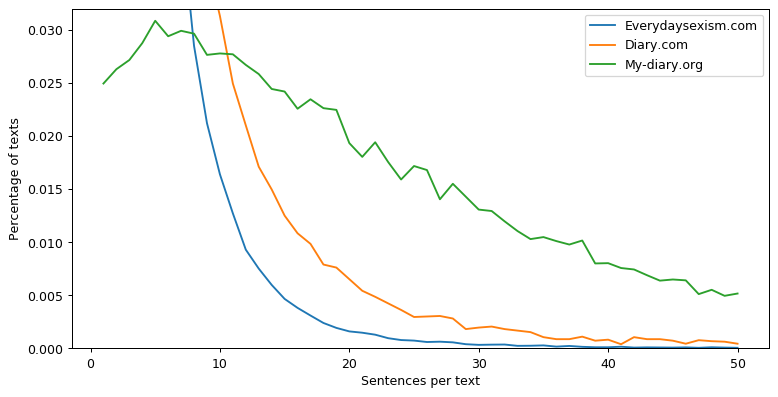

In [15]:
discrimination.texts.sentences_plot(list_of_texts, (0,0.032), 50, [10,5], 90, legend)

Texts from everydaysexism.com and diary.com have way less sentences than my-diary.org. Use a hard limit and split all texts of my-diary.org until they are up to 20 sentences long at most.

In [16]:
texts = []
for sentences in sentences_mydiary:
    division = round( len(sentences) / 20 )
    for i in range(division + 1):
        text = "".join(sentences[20*i : 20*(i+1)])
        if len(text) >= 20:
            texts.append(text)
            
sentences_mydiary2 = discrimination.texts.sentences_split(texts)

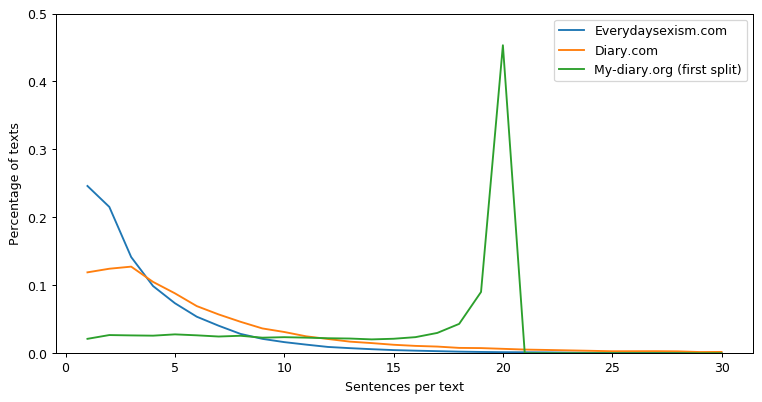

In [17]:
list_of_texts = [sentences_everydaysexism, sentences_diary, sentences_mydiary2]
legend = ["Everydaysexism.com", "Diary.com", "My-diary.org (first split)"]
discrimination.texts.sentences_plot(list_of_texts, (0,0.5), 30, [10,5], 90, legend)

This has created obviously a very large spike at 20 sentences (~45%) of the texts. What we can do is take a normal distribution with $\mu=2$ and $\sigma = 6$. Then we will discard non-positive values and round all other values to the closest integer. This draw will -almost- be a half-normal with $\mu=2$ and $\sigma = 6$. It will be able to reproduce, to some extent, the distribution of everydaysexism.com texts, where many texts have just one or two sentences, and will also have all 99.6% of texts having between 1 and $\mu + 3\times\sigma = 20$ sentences. (It won't however look like a half-normal cause when splitting $x$, the number of sentnces in $x_1$ follows this distribution, but the number of sentences left in $x_2 = x -x_1$ does not).

...well after a little tweaking, setting $\mu=4$ and $\sigma=7$ makes the distribution resemble the everyday sexism one. So I'll settle for this.

In [18]:
texts.clear()

for sentences in sentences_mydiary2:   
    draw = -1
    while draw <= 0:
        draw = int(round(random.normalvariate(4,7),0))
    
    division = round( len(sentences) / draw )
    
    for i in range(division + 1):   
        text = "".join(sentences[draw*i : draw*(i+1)])
        if len(text) >= 20:
            texts.append(text)

sentences_mydiary3 = discrimination.texts.sentences_split(texts)

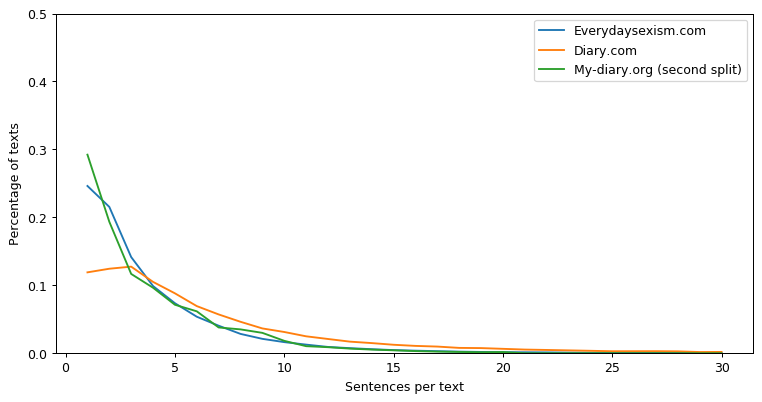

In [19]:
list_of_texts = [sentences_everydaysexism, sentences_diary, sentences_mydiary3]
legend = ["Everydaysexism.com", "Diary.com", "My-diary.org (second split)"]
discrimination.texts.sentences_plot(list_of_texts, (0,0.5), 30, [10,5], 90, legend)

This looks good. Make "texts_mydiary" equal to the final "texts" variable and move on.

In [20]:
texts_mydiary = texts

In [32]:
print("37K of English texs collected resulted in", len(texts_mydiary), "after splitting")

37K of English texs collected resulted in 331425 after splitting


## Tokenize texts<sup>1</sup>, spell-check each word<sup>2</sup>, remove stop-words again, discard the empty resulting tokens and the ones with just one word. Save.

<sup>1</sup> Tokens only contain letters, words with letters and numbers are discarded.  
<sup>2</sup> If the word does not exist in the dictionary, then all existing words that are 1 letter "change" away are found. For example, from the words *cta*, *cet*, *ca*, *catt*, the word *cat* is respectively one neighbouring letter-swap, letter-change, letter addition and letter removal away. After all such words are found in the dictionary, the most frequent one is chosen to substitute the misspelled word.

In [ ]:
# Tokenize texts and remove stop-words
tokens_diary = discrimination.texts.tokenize(texts_diary)
tokens_mydiary = discrimination.texts.tokenize(texts_mydiary)
tokens_everydaysexism = discrimination.texts.tokenize(texts_everydaysexism)

# Spell-check tokens. This actually takes some time (not too much) so there's a timer every 20.000 tokens checked.
tokens_diary = discrimination.texts.spellcheck_tokens(tokens_diary)
tokens_mydiary = discrimination.texts.spellcheck_tokens(tokens_mydiary)
tokens_everydaysexism = discrimination.texts.spellcheck_tokens(tokens_everydaysexism)

# Remove stop-words a second time, in case some stopwords where misspelled.
tokens_diary = discrimination.texts.remove_stopwords(tokens_diary)
tokens_mydiary = discrimination.texts.remove_stopwords(tokens_mydiary)
tokens_everydaysexism = discrimination.texts.remove_stopwords(tokens_everydaysexism)

# Before discarding some tokens, keep a copy of the original ones.
tokens_diary_all = tokens_diary.copy()
tokens_mydiary_all = tokens_mydiary.copy()
tokens_everydaysexism_all = tokens_everydaysexism.copy()

# Discard tokens with 0 or 1 words.
for tokens in [tokens_diary, tokens_mydiary, tokens_everydaysexism]:
    temp = tokens.copy()
    tokens.clear()
    for token in temp:
        if len(token) > 1:
            tokens.append(token)

In [23]:
# Save
# pickle.dump(tokens_diary, open("pickles/tokens_diary.p", "wb"))
# pickle.dump(tokens_mydiary, open("pickles/tokens_mydiary.p", "wb"))
# pickle.dump(tokens_everydaysexism, open("pickles/tokens_everydaysexism.p", "wb"))
# pickle.dump(tokens_diary_all, open("pickles/tokens_diary_all.p", "wb"))
# pickle.dump(tokens_mydiary_all, open("pickles/tokens_mydiary_all.p", "wb"))
# pickle.dump(tokens_everydaysexism_all, open("pickles/tokens_everydaysexism_all.p", "wb"))

# Load
tokens_diary = pickle.load(open("pickles/tokens_diary.p", "rb"))
tokens_mydiary = pickle.load(open("pickles/tokens_mydiary.p", "rb"))
tokens_everydaysexism = pickle.load(open("pickles/tokens_everydaysexism.p", "rb"))
tokens_diary_all = pickle.load(open("pickles/tokens_diary_all.p", "rb"))
tokens_mydiary_all = pickle.load(open("pickles/tokens_mydiary_all.p", "rb"))
tokens_everydaysexism_all = pickle.load(open("pickles/tokens_everydaysexism_all.p", "rb"))

## Convert tokens back to text (so Keras can be happy) and labels for these texts. Keep a record of original texts, tokens, tokens-to-texts, labels. Save.

The record is needed so that later on we can check the prediction for tokens of interest (e.g. the borderline sexist ones) and easily access the original text.

In [ ]:
# Convert tokens back to text for Keras
texts_keras = []
for token in itertools.chain(tokens_diary, tokens_mydiary, tokens_everydaysexism):
    text = ""
    for word in token:
        text += word + " "        
    texts_keras.append(text)

# Create labels
labels_keras = np.zeros(len(texts_keras))
labels_keras[-len(tokens_everydaysexism):] = 1

# Record texts, tokens
record = []
for text, token in zip(texts_diary, tokens_diary_all):
    record.append({"text": text, "token": token, "truth": 0})
for text, token in zip(texts_mydiary, tokens_mydiary_all):
    record.append({"text": text, "token": token, "truth": 0})
for text, token in zip(texts_everydaysexism, tokens_everydaysexism_all):
    record.append({"text": text, "token": token, "truth": 1})

# Add the tokens-to-text in the record
for entry in record:
    token_to_text = ""
    for word in entry["token"]:
        token_to_text += word + " "        
    entry["token_to_text"] = token_to_text

In [88]:
# Save
# pickle.dump(record, open("pickles/record.p", "wb"))
# pickle.dump(texts_keras, open("pickles/texts_keras.p", "wb"))
# pickle.dump(labels_keras, open("pickles/labels_keras.p", "wb"))

# Load
record = pickle.load(open("pickles/record.p", "rb"))
texts_keras = pickle.load(open("pickles/texts_keras.p", "rb"))
labels_keras = pickle.load(open("pickles/labels_keras.p", "rb"))

In [89]:
print(len(labels_keras) - len(tokens_everydaysexism), "non-sexist tokens and", len(tokens_everydaysexism), "sexist ones.")

NameError: name 'tokens_everydaysexism' is not defined

# 2. Neural Network in Keras

## Data\Labels preparation and save. Parse the word embeddings, create the embedding layer.

In [90]:
# Tokenizing - Sequencing
tokenizer = Tokenizer(lower = False)
tokenizer.fit_on_texts(texts_keras)
sequences = tokenizer.texts_to_sequences(texts_keras)
word_index = tokenizer.word_index

# Create and shuffle data and labels
data = pad_sequences(sequences, maxlen=256)
labels = np.asarray(labels_keras)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Save data and labels
pickle.dump(data, open("pickles/data.p", "wb"))
pickle.dump(labels, open("pickles/labels.p", "wb"))

# Split 80-20
nb_validation_samples = int(0.2 * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [93]:
# Parse the GloVe word embeddings
glove_dir = "glove/"
embeddings_index = {}
f = open(os.path.join(glove_dir, "glove.42B.300d.txt"))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

# Create the embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
# Delete the embeddings index as it's no longer needed.
del embeddings_index
# Create the embedding layer
embedding_layer = Embedding(len(word_index) + 1, 300, input_length=256,
                            weights=[embedding_matrix],
                            trainable=False)

## Network setup, compilation, results, testing. Save model weights.

In [95]:
# Setup
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu", kernel_regularizer = regularizers.l2(0.001)))
# model.add(Dense(16, activation="relu", kernel_regularizer = regularizers.l2(0.001)))
model.add(Dense(16, activation="relu", kernel_regularizer = regularizers.l2(0.001)))
# model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 300)          26585700  
_________________________________________________________________
flatten_2 (Flatten)          (None, 76800)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 76800)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               19661056  
_________________________________________________________________
dense_5 (Dense)              (None, 16)                4112      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 46,250,885
Trainable params: 19,665,185
Non-trainable params: 26,585,700
_________________________________

In [ ]:
# Compilation
model.compile(optimizer = "Adam",
              loss = "binary_crossentropy",
              metrics = ["acc"])
history = model.fit(x_train, y_train,
                    epochs = 3,
                    batch_size = 256,
                    validation_data = (x_val, y_val))

# Save model weights
model.save_weights("pickles/glove_model.h5")

Train on 350126 samples, validate on 87531 samples
Epoch 1/3
350126/350126 [==============================] - 1075s 3ms/step - loss: 0.4050 - acc: 0.8954 - val_loss: 0.3127 - val_acc: 0.9217
Epoch 2/3
350126/350126 [==============================] - 4137s 12ms/step - loss: 0.3382 - acc: 0.9112 - val_loss: 0.2875 - val_acc: 0.9252
Epoch 3/3
268288/350126 [=====================>........] - ETA: 13:16 - loss: 0.3169 - acc: 0.9150

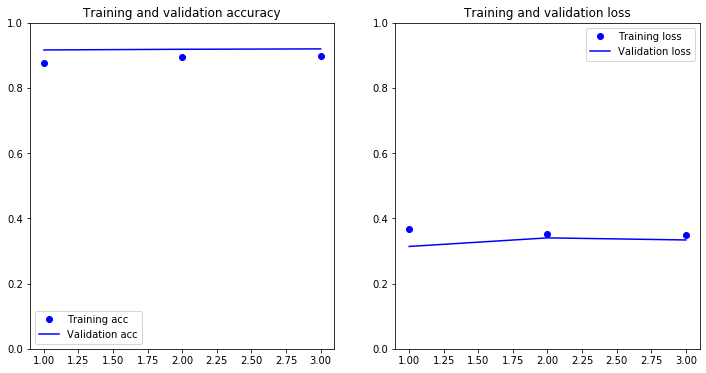

In [37]:
# Make some graphs
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize = [12,6])

# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "bo", label = "Training acc")
plt.plot(epochs, val_acc, "b", label = "Validation acc")
plt.title("Training and validation accuracy")
plt.ylim([0,1])
plt.legend()
# Loss graph
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and validation loss")
plt.ylim([0,1])
plt.legend()

plt.show()

## Test the model!

In [91]:
# Test the network
test = ["Let's be real here, most humans, male or female, aren't going to play on tour.  @BLAIRONEAL and @PaigeSpiranac are well above average golfers who happen to catch the eye of a specific demographic.  How exactly are they devaluing the LPGA/Womens' sports? "]

# Convert the test phrase to lowercase, tokenize, spellcheck, remove stopwords. 
test = discrimination.texts.lowercase(test)
test = discrimination.texts.tokenize(test)
test = discrimination.texts.spellcheck_tokens(test)
test = discrimination.texts.remove_stopwords(test)
# Convert the token back to text, sequence it, pad it, feed it into the model.
text = ""
for item in test:
    for word in item:
        text += word + " "        
test_sequence = tokenizer.texts_to_sequences([text])
x_test = pad_sequences(test_sequence, maxlen=256)
model.load_weights("pickles/glove_model.h5")
# Make the output look pretty... because it deserves it.
str(round(model.predict(x_test)[0,0]*100,0))[:-2] + "% sexist"

NameError: name 'model' is not defined

# 3. Borderline results

In [38]:
# Get all model predictions
model.load_weights("pickles/glove_model.h5")
# predictions = model.predict(data)

In [52]:
# Define the borderline
borderline = [0.49, 0.50]

# Find all tokens that are on the borderline
borderline_tokens = []
for i, prediction in enumerate(predictions):
    if borderline[0] <= prediction[0] <= borderline[1]: 
        token = texts_keras[i]
        sexist = labels_keras[i]
        borderline_tokens.append((token, prediction[0], sexist))

# Create a list with all the borderline texts
borderline_texts = []
for token in borderline_tokens:
    if token[2]==1:
        for entry in record:
            if entry["token_to_text"] == token[0]:
                borderline_texts.append({"text": entry["text"], "prediction": token[1], "truth": 1})
    else:
        for entry in record:
            if entry["token_to_text"] == token[0]:
                borderline_texts.append({"text": entry["text"], "prediction": token[1], "truth": 0})
                
# Make the list into a DataFrame
df_borderline = pd.DataFrame(borderline_texts, columns = ["text", "prediction", "truth"])

In [53]:
# Save
pickle.dump(df_borderline, open("pickles/df_borderline.p", "wb"))

# Load
df_borderline = pickle.load(open("pickles/df_borderline.p", "rb"))

In [54]:
pd.set_option('display.max_colwidth', 0)
df_borderline[df_borderline["truth"]==1].head(3)

,text,prediction,truth
1122,I often encounter sexism not from males but from my female counterparts and it riles me terribly. One woman thinks women ‘cannot have it all’ and has very traditional views about how women should forsake career for family. She won’t consider that women should have it all and that the law and attitudes needs to change. She doesn’t even think women who are harassed have a case and seems to think ‘lads will be lads’ and that’s okay. I can’t get over this kind of galling sexism that I seem to face almost daily from other women. What’s worrying is she is bringing up two boys so will only pass her narrowminded views on to them.,0.493206,1
1123,"When I was a freshman (age 18) at a large university, I was walking uphill toward the student housing complex where I lived. An older man who was also climbing the hill started talking to me. He appeared to be much older than I was (maybe 20 years older?); I saw streaks of gray in his dark hair. He said that he had seen me from the window of his apartment nextdoor to the building I lived in. He asked me out for coffee, and I declined. This incident really freaked me out, because if he was telling the truth, he knew where I lived. I was very young and naive at the time. I saw him from afar a few other times and kept my distance and had no further interaction with him (thankfully).",0.494028,1
1124,"My daughter in law stacking lower shelves at a grocery store. A customer says to her, ‘You look like you spend a lot of time on your knees’, she replies, ‘excuse me?’ To which he answered, ‘You look like the kind of girl who likes to spend time on your knees in front of a man.’",0.495193,1


# 4. Word frequencies

## Retrieve the common vocabulary (sexist & non-sexist texts). Order it by frequency for each type of texts. Save.

In [41]:
# Temp variables
temp_list = []
temp_sexist = []
temp_nonsexist = []

# Retrieve sexist vocabulary and convert tokens into sets
sexist_vocabulary = set()
for token in tokens_everydaysexism: 
    x = set(token)
    sexist_vocabulary |= x
    temp_sexist.append(x)

# Retrieve non-sexist vocabulary and convert tokens into sets
nonsexist_vocabulary = set()
for token in itertools.chain(tokens_diary, tokens_mydiary):
    x = set(token)
    nonsexist_vocabulary |= x
    temp_nonsexist.append(x)
    
# Retrieve common vocabulary
common_vocabulary = sexist_vocabulary & nonsexist_vocabulary

I measure frequency by $\frac{\text{number of tokens word appears in}}{\text{number of tokens}}$. This is done separately for each word in the sexist and non-sexist texts so that comparisons can be made. This takes some time (around 30 minutes).

In [46]:
# Frequency denominators
denominator_sexist = len(temp_sexist)
denominator_nonsexist = len(temp_nonsexist)

# Frequency numerators
for word in tqdm.tqdm(common_vocabulary):
    timer += 1
    numerator_sexist = 0
    numerator_nonsexist = 0
    
    for token in temp_sexist:
        if word in token:
            token -= set(word)
            numerator_sexist += 1
            
    for token in temp_nonsexist:
        if word in token:
            token -= set(word)
            numerator_nonsexist += 1
    
    # Calculate word frequencies
    pct_sexist = numerator_sexist / denominator_sexist
    pct_nonsexist = numerator_nonsexist / denominator_nonsexist
    
    # Add info to the temp list
    temp_list.append({'word': word, 'pct_sexist': pct_sexist, 'pct_nonsexist': pct_nonsexist})
        
# Make the list into a DataFrame
df_word_rank = pd.DataFrame(temp_list, columns = ["word", "pct_sexist", "pct_nonsexist"])

  0%|          | 60/30362 [00:04<36:15, 13.93it/s]


KeyboardInterrupt: 

In [3]:
# Save
# pickle.dump(df_word_rank, open("pickles/df_word_rank.p", "wb"))

# Load
df_word_rank = pickle.load(open("pickles/df_word_rank.p", "rb"))

## Using the word frequencies, create a dataframe so that the top-x most common words in sexist texts can be retrieved and compared with their non-sexist rank. Also do the opposite, i.e. top-x most common words in non-sexist texts can be retrieved and compared with their sexist rank.

In [4]:
# Show percentages as integers from 0 to 100.
df_word_rank["pct_sexist"] = round(df_word_rank["pct_sexist"] * 100, 1)
df_word_rank["pct_nonsexist"] = round(df_word_rank["pct_nonsexist"] * 100, 1)
# Create NonSexist Rank
df_word_rank = df_word_rank.sort_values(by="pct_nonsexist", ascending = False)
df_word_rank = df_word_rank.reset_index(drop=True)
df_word_rank["nonsexist_rank"] = 1 + df_word_rank.index
# Create Sexist Rank
df_word_rank = df_word_rank.sort_values(by="pct_sexist", ascending = False)
df_word_rank = df_word_rank.reset_index(drop=True)
df_word_rank["sexist_rank"] = 1 + df_word_rank.index
# Reorder columns
df_word_rank = df_word_rank[["word", "pct_sexist", "sexist_rank", "nonsexist_rank", "pct_nonsexist"]]
# Add Rank Difference, Absolute Rank Difference, and Rank Difference Squared columns
df_word_rank["abs_rank_diff"] = abs( df_word_rank["nonsexist_rank"] - df_word_rank["sexist_rank"] )
df_word_rank["sq_rank_diff"] = df_word_rank["abs_rank_diff"] ** 2

In [6]:
# Interested in Top-X, where...
X = 20

# Print Statistics
print("Absolute Rank Difference (Sexist vs Non-Sexist) of top-100 words is " + str(df_word_rank["abs_rank_diff"][:X].mean()))
print("Rank Difference Squared (Sexist vs Non-Sexist) of top-100 words is " + str(df_word_rank["sq_rank_diff"][:X].mean()))

# Display the dataframe
pd.set_option('display.max_rows', 50)
df_word_rank.head(X)

Absolute Rank Difference (Sexist vs Non-Sexist) of top-100 words is 135.2
Rank Difference Squared (Sexist vs Non-Sexist) of top-100 words is 61221.1


,word,pct_sexist,sexist_rank,nonsexist_rank,pct_nonsexist,abs_rank_diff,sq_rank_diff
0,one,1960.0,1,3,1320.0,2,4
1,told,1960.0,2,38,530.0,36,1296
2,man,1930.0,3,151,220.0,148,21904
3,said,1840.0,4,24,680.0,20,400
4,like,1730.0,5,1,1730.0,4,16
5,men,1660.0,6,543,70.0,537,288369
6,get,1620.0,7,5,1290.0,2,4
7,women,1560.0,8,564,70.0,556,309136
8,would,1540.0,9,6,1070.0,3,9
9,male,1430.0,10,695,50.0,685,469225


# TEST LIST OF TOP-X
----

In [70]:
# Get a list of top-X ranked sexist words that are not even in the top-Y ranked non-sexist words
X = 20
Y = 200

top_X_not_in_top_Y = df_word_rank.head(X)[df_word_rank.head(X)["nonsexist_rank"] > Y]
list_of_words = list(top_X_not_in_top_Y.word)

# Using this list, create n random samples of k words.
n = 4
k = 3
samples = []

for i in range(n):
    sample = random.sample(list_of_words, k)
    samples.append(sample)

In [73]:
samples[0:3]

[['women', 'woman', 'male'],
 ['men', 'woman', 'women'],
 ['male', 'woman', 'men']]

In [76]:
# Using these samples search and scrape tweets that have all words in each sample
for sample in samples[0:3]:
    discrimination.twitter.search_scrape(database="test_data", language="en", all_words = sample)

INFO: queries: ['women woman male         since:2006-03-21 until:2006-11-25', 'women woman male         since:2006-11-25 until:2007-08-02', 'women woman male         since:2007-08-02 until:2008-04-08', 'women woman male         since:2008-04-08 until:2008-12-14', 'women woman male         since:2008-12-14 until:2009-08-21', 'women woman male         since:2009-08-21 until:2010-04-28', 'women woman male         since:2010-04-28 until:2011-01-03', 'women woman male         since:2011-01-03 until:2011-09-10', 'women woman male         since:2011-09-10 until:2012-05-17', 'women woman male         since:2012-05-17 until:2013-01-22', 'women woman male         since:2013-01-22 until:2013-09-29', 'women woman male         since:2013-09-29 until:2014-06-06', 'women woman male         since:2014-06-06 until:2015-02-11', 'women woman male         since:2015-02-11 until:2015-10-19', 'women woman male         since:2015-10-19 until:2016-06-25', 'women woman male         since:2016-06-25 until:2017-

KeyboardInterrupt: 

In [77]:
discrimination.mongo.list_collections(database="test_data")

['twitter_queries_scraped', 'twitter']

In [78]:
table = discrimination.mongo.collection(database="test_data", collection="twitter")
# table.drop()
temp_list = []
for x in table.find():
    temp_list.append(x)

In [79]:
len(temp_list)

71831

In [80]:
temp_list[0]
temp_df = pd.DataFrame(temp_list, columns = ["text", "account"])

In [85]:
pd.set_option('display.max_colwidth', 0)
temp_df.text.sample(100)

52202    When a male puts his word in on womens issues we are told we're trying to steal focus from womens issues.\nTelling me that male issues matter not on the day it matters but on a day im told to "get a day of our own" is not helping.                                                             
51331    Flub of the year. One of the world's oldest male dominated institutions making a woman cleaner remove a chalk tribute to women on International women's day.  https://twitter.com/DrSophieSmith/status/971714934819184640 …                                                                        
42854    As a female around here, if you share a male with other women, be very careful giving your attention to another man but the one who you're supposed to stay attached to, or you'll be left out in the cold. They're an all women man. But you're supposed to stay a one man woman.                 
39187    By definition, "transwomen" are male.\n\nYou can only BE  a transwoman, if you are male.

# Continue old
----

In [46]:
# Order by NonSexist Rank
df_word_rank = df_word_rank.sort_values(by="pct_nonsexist", ascending = False)
df_word_rank = df_word_rank.reset_index(drop=True)

In [47]:
# Print Statistics
print("Absolute Rank Difference (Non-Sexist vs Sexist) of top-100 words is " + str(df_word_rank["abs_rank_diff"][:X].mean()))
print("Rank Difference Squared (Non-Sexist vs Sexist) of top-100 words is " + str(df_word_rank["sq_rank_diff"][:X].mean()))

# Display the dataframe
df_word_rank.head(X)

Absolute Rank Difference (Non-Sexist vs Sexist) of top-100 words is 13.5
Rank Difference Squared (Non-Sexist vs Sexist) of top-100 words is 319.7


,word,pct_sexist,sexist_rank,nonsexist_rank,pct_nonsexist,abs_rank_diff,sq_rank_diff
0,like,1730.0,5,1,1730.0,4,16
1,know,1050.0,19,2,1360.0,17,289
2,one,1960.0,1,3,1320.0,2,4
3,time,1350.0,11,4,1300.0,7,49
4,get,1620.0,7,5,1290.0,2,4
5,would,1540.0,9,6,1070.0,3,9
6,want,800.0,41,7,1010.0,34,1156
7,really,840.0,35,8,1010.0,27,729
8,think,820.0,38,9,1000.0,29,841
9,back,990.0,20,10,950.0,10,100


# 5. Confusion Matrix and distribution of scores

## Confusion matrix

In [48]:
# Create a predicted labels list
labels_predicted = []
for prediction in predictions:
    labels_predicted.append( round(prediction[0]) )
# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
CF = confusion_matrix(labels, labels_predicted)
#"Disentangle" the matrix
TN = round((CF[0,0] / sum(CF[0,:])) * 100, 1)
FN = round((CF[0,1] / sum(CF[0,:])) * 100, 1)
TP = round((CF[1,1] / sum(CF[1,:])) * 100, 1)
FP = round((CF[1,0] / sum(CF[1,:])) * 100, 1)
GTN = round((CF[0,0] / (sum(CF[0,:]) + sum(CF[1,:]))) * 100, 1)
GFN = round((CF[0,1] / (sum(CF[0,:]) + sum(CF[1,:]))) * 100, 1)
GTP = round((CF[1,1] / (sum(CF[0,:]) + sum(CF[1,:]))) * 100, 1)
GFP = round((CF[1,0] / (sum(CF[0,:]) + sum(CF[1,:]))) * 100, 1)
# Print the results
print("True positives account for "+str(TP)+"% or "+str(GTP)+"% of the total (sexist texts labelled as sexist).")
print("True negatives account for "+str(TN)+"% or "+str(GTN)+"% of the total (non-sexist texts labelled as non-sexist).")
print("False positives account for "+str(FP)+"% or "+str(GFP)+"% of the total (sexist texts labelled as non-sexist).")
print("False negatives account for "+str(FN)+"% or "+str(GFN)+"% of the total (non-sexist texts labelled as sexist).")

True positives account for 78.5% or 17.4% of the total (sexist texts labelled as sexist).
True negatives account for 96.3% or 75.0% of the total (non-sexist texts labelled as non-sexist).
False positives account for 21.5% or 4.7% of the total (sexist texts labelled as non-sexist).
False negatives account for 3.7% or 2.9% of the total (non-sexist texts labelled as sexist).


## Distribution of scores

In [49]:
# Record all predictions (x) but also seperately for each class (x_sexist and x_nonsexist).
x = []
x_sexist = []
x_nonsexist = []
for i, p in enumerate(predictions):
    x.append(p[0])
    if labels[i] == 1:
        x_sexist.append(p[0])
    else:
        x_nonsexist.append(p[0])

# Transform predictions in the 0-100 range, and round them up to the nearast integer.        
x_100 = []
x_sexist_100 = []
x_nonsexist_100 = []
for item in x:
    x_100.append(round(item*100))
for item in x_sexist:
    x_sexist_100.append(round(item*100))
for item in x_nonsexist:
    x_nonsexist_100.append(round(item*100))

# Count the (rounded) predictions and transform to percentages.
y = []
y_sexist = []
y_nonsexist = []
for i in range(101):
       y.append(100*x_100.count(i)/len(x_100))
for i in range(101):
       y_sexist.append(100*x_sexist_100.count(i)/len(x_sexist_100))
for i in range(101):
       y_nonsexist.append(100*x_nonsexist_100.count(i)/len(x_nonsexist_100))

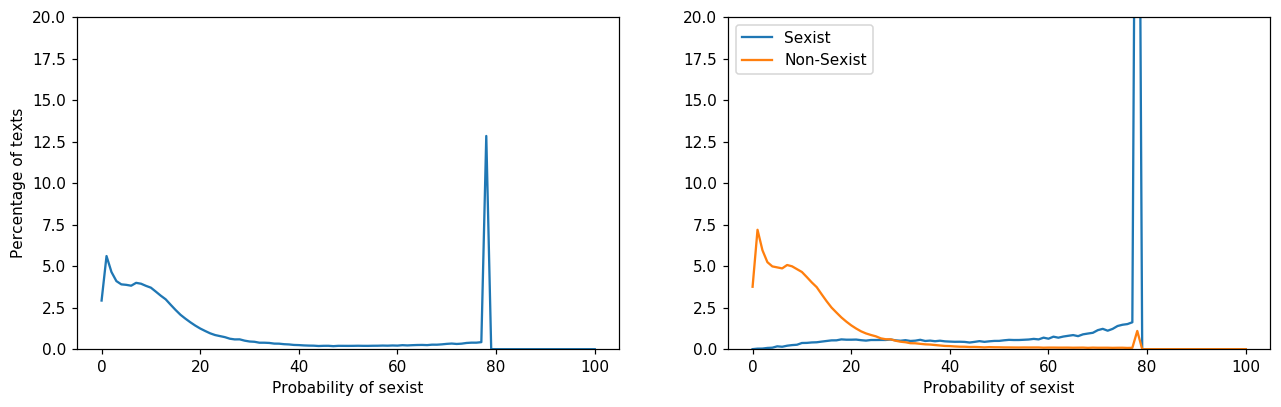

In [50]:
plt.figure(figsize=[14,4], dpi=110)
plt.subplot(1,2,1)
plt.ylim([0,20])
plt.plot(range(101), y)
plt.xlabel("Probability of sexist")
plt.ylabel("Percentage of texts")

plt.subplot(1,2,2)
plt.ylim([0,20])
plt.plot(range(101), y_sexist)
plt.plot(range(101), y_nonsexist)
plt.legend(["Sexist", "Non-Sexist"])
plt.xlabel("Probability of sexist");

Zoom-in a little bit...

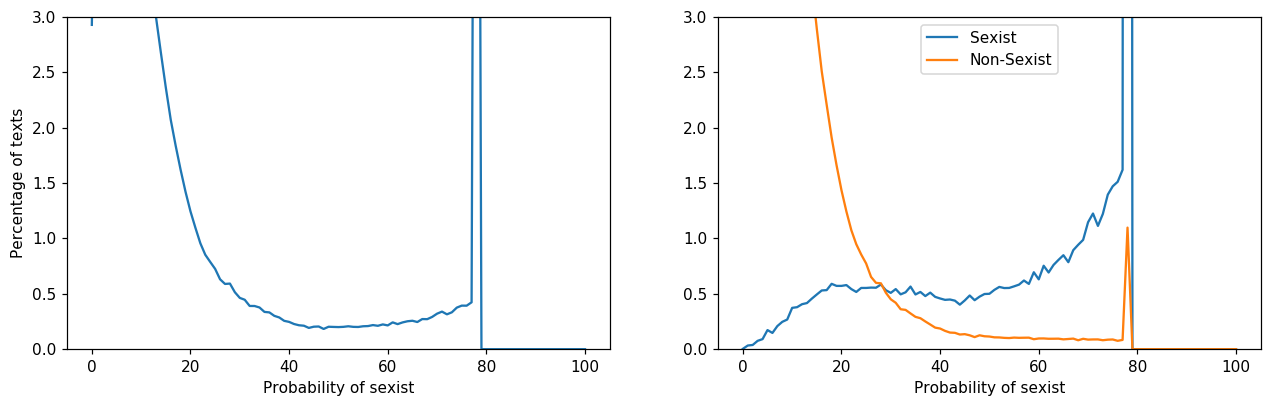

In [51]:
plt.figure(figsize=[14,4], dpi=110)
plt.subplot(1,2,1)
plt.ylim([0,3])
plt.plot(range(101), y)
plt.xlabel("Probability of sexist")
plt.ylabel("Percentage of texts")

plt.subplot(1,2,2)
plt.ylim([0,3])
plt.plot(range(101), y_sexist)
plt.plot(range(101), y_nonsexist)
plt.legend(["Sexist", "Non-Sexist"])
plt.xlabel("Probability of sexist");